# Modeling

- a set of ideas and numbers that describe the past, present, or future state of something such as an economy

motivations for modeling
- predict future
- filling data gaps
- identify undelying processes
- a framework for experimentation
- quantify processes by tuning parameters to help model match observations

### Variables
- quantity that can have varying values in space and time
- known or unknown

### Parameters
- constants
- define the relationships among the variables
- quantify the strength of realtionship under different conditions


# NPZ (nutrient-phytoplankton-zooplankton) model

Exploring a three component ecosystem model.

$\mu $ = specific growth rate [$days^-1$] 

<img src='images/growth_rate.png' width="600">



### Equations

3 ordinary differential equations

coupled

initial value problem(need to specify intial conditions)

Change in Phytoplankton Population = Photosynthesis - Grazing - Mortality

$ \frac{dP}{dT} = V_m \frac {N}{K_s +N}P-R_m \frac{P}{K_G + P}G -mP$

Vm = max phtyoplankton growth rate

ks = half-saturation constant for phytoplankton N uptake

P = phytoplankton

m = mortality rate 

Change in Zooplankton Population = Growth due to grazing - Mortality Rate

$ \frac{dZ}{dT} = (1-\gamma)R_m \frac{p}{K_G + P}Z - gZ$

$\gamma$ = sloppy feeding parameter

g = zooplankton mortality rate 

Change in Nitrogen = phytoplankton reassimilation + Zooplankton reassimilation + unassimilated fraction of zoo grazing - phytoplankton uptake

$\frac{dN}{dt}= gZ + mP + \gamma Rm \frac{P}{K_G + P}Z$


Therefore to predict at a future time ($Variable_1$) we need an initial condition:

$N_1 = N_0 + \frac {dN}{dt} \Delta t$

$P_1 = P_0 + \frac {dP}{dt} \Delta t$

$Z_1 = Z_0 + \frac {dZ}{dt} \Delta t$

This is Eulers method, one of the simplest ways of discretizing equations

### Exercises
1. Choose a parameter, make a prediction about how that parameter will alter the model, then systematically test the results of changing that parameter.
2. Experiment with changing the functional form of zooplankton grazing. What differences do you notice?
3. Try to "blow up" the model. Take notes on how to make the model attain unrealistic values (e.g. negative concentrations, or total mass of nitrogen is not conserved).

In [27]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt

## Select parameters and zooplankton predation type 

#### Parameter values

Default values from Franks et al. (1986):

`
Vm = 2.      # max phtyoplankton growth rate
Rm = 1.5     # max zooplankton ingestion rate
ks = 1.      # half-saturation constant for phytoplankton N uptake 
m = 0.1      # phytoplankton mortality
kg = 1.      # grazing half saturation or (1/Ivlev constant)
lmbda = 0.2  # unassimilated phytoplankton fraction
g = 0.2      # zooplankton mortality
`

In [28]:
Vm = 2.      # max phtyoplankton growth rate
Rm = 1.5     # max zooplankton ingestion rate
ks = 1.      # half-saturation constant for phytoplankton N uptake 
m = 0.1      # phytoplankton mortality
kg = 1.      # grazing half saturation or (1/Ivlev constant)
lmbda = 0.2  # unassimilated phytoplankton fraction
g = 0.2      # zooplankton mortality

#### Zooplankton predation functional type

Options:
* `'M-M'` (Michaelis-Menten, *default*)

$$ I = R_m \frac{P}{k_g+P}Z $$

* `'quadratic'`

$$ I = R_m \frac{P^2}{k_g^2+P^2}Z $$

* `'Ivlev'`

$$ I = R_m\left[1-\exp(-k_g^{-1}P) \right]Z $$

* `'M-P'` (Mayzaud-Poulet)

$$ I = R_m k_g^{-1}P \left[1-\exp(-k_g^{-1}P) \right]Z $$

In [29]:
predation_type = 'M-P' 

## Define time step and initial conditions

In [30]:
dt = 0.0001 # time step [days]
t = np.arange(0,5,dt)

# initialize arrays of NaNs for all times
P = np.nan*t # phytoplankton
N = np.nan*t # nitrate
Z = np.nan*t # zooplankton

Initial conditions at time $t = 0$

In [31]:
P[0] = 1
N[0] = 3
Z[0] = 1

## Zooplankton ingestion function

Zooplankton specific ingestion rate as a function of phytoplankton concentration. This is a functional relationship defined by the model parameters, and does not change with time.

In [32]:
def ingestion(P,Rm,predation_type):
    if predation_type == 'quadratic':
        I = Rm*(P**2/(kg**2+P**2))
    elif predation_type == 'Ivlev':
        I = Rm*(1-np.exp(-kg**-1*P))
    elif predation_type == 'M-P':
        I = Rm*(kg**-1*P*(1-np.exp(-kg**-1*P)))
    else:
        I = Rm*(P/(kg+P))
    return I

<IPython.core.display.Javascript object>


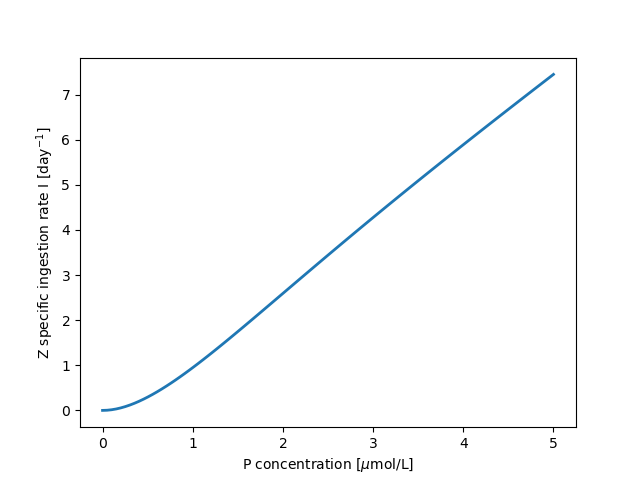

Text(0,0.5,'Z specific ingestion rate I [day$^{-1}$]')

In [33]:
NT = P[0]+N[0]+Z[0]
Pf = np.linspace(0,NT,100)
If = ingestion(Pf,Rm,predation_type)

plt.figure()
plt.plot(Pf,If,lw=2)
plt.xlabel('P concentration [$\mu$mol/L]')
plt.ylabel('Z specific ingestion rate I [day$^{-1}$]')

## Phytoplankton growth function

Phtyoplankton specific growth rate as a function of nutrient concentration. This is a functional relationship defined by the model parameters, and does not change with time.

In [34]:
def phyto_growth_rate(N,Vm,ks):
    mu = Vm*N/(ks+N) # growth rate [day^-1]
    return mu

<IPython.core.display.Javascript object>


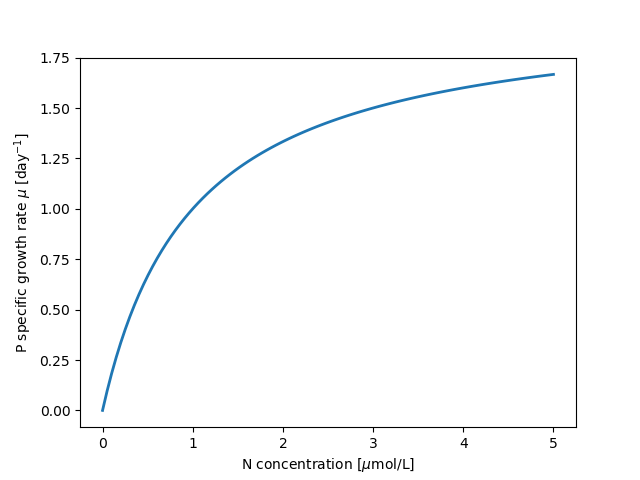

Text(0,0.5,'P specific growth rate $\\mu$ [day$^{-1}$]')

In [35]:
Nf = np.linspace(0,NT,100)
muf = phyto_growth_rate(Nf,Vm,ks)

plt.figure()
plt.plot(Nf,muf,lw=2)
plt.xlabel('N concentration [$\mu$mol/L]')
plt.ylabel('P specific growth rate $\mu$ [day$^{-1}$]')

## Model calculations

Starting from initial conditions and using a loop to step forward in time (Euler's method).

In [36]:
for i,time in enumerate(t[1:]):   
    prod = P[i]*phyto_growth_rate(N[i],Vm,ks) # production rate, dP/dt [cells L^-1 day^-1]
    remin = P[i]*m
    grazing = ingestion(P[i],Rm,predation_type)*Z[i]
    zmort = g*Z[i]
    
    P[i+1] = P[i] + (prod - remin - grazing)*dt
    N[i+1] = N[i] + (-prod + remin + zmort + lmbda*grazing)*dt
    Z[i+1] = Z[i] + ((1-lmbda)*grazing - zmort)*dt

## Time series plots of nitrogen, phytoplankton and zooplankton

<IPython.core.display.Javascript object>


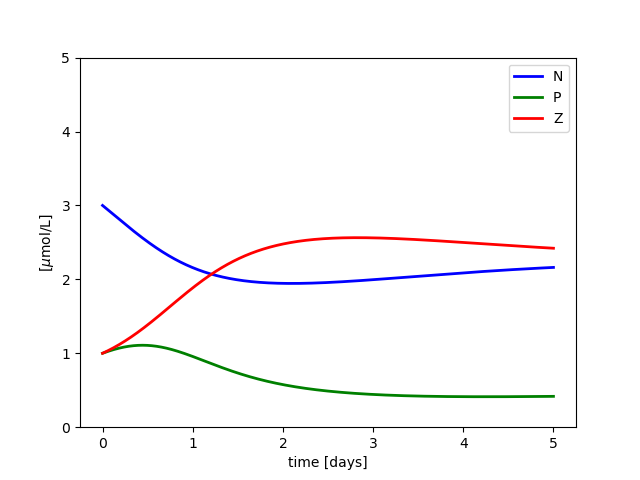

In [37]:
plt.figure()
plt.plot(t,N,color='b',lw=2)
plt.plot(t,P,color='g',lw=2)
plt.plot(t,Z,color='r',lw=2)
plt.ylim([0,NT])
plt.xlabel('time [days]')
plt.ylabel('[$\mu$mol/L]')
plt.legend(['N','P','Z'],loc='best')

## Phase plane diagram of phytoplankton vs. zooplankton

<IPython.core.display.Javascript object>


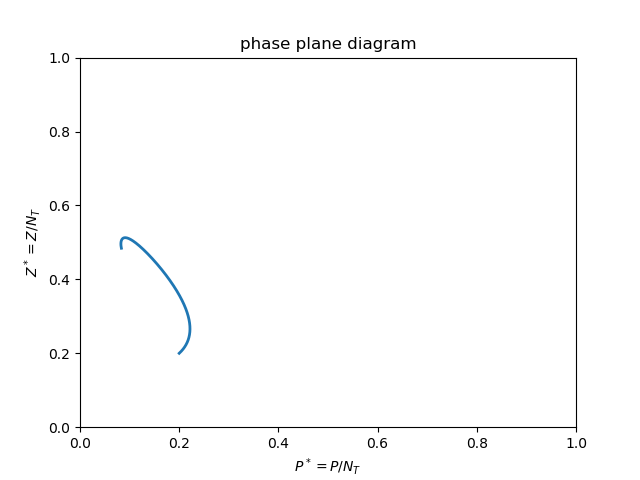

Text(0.5,1,'phase plane diagram')

In [38]:
plt.figure()
plt.plot(P/NT,Z/NT,lw=2)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('$P^* = P/N_T$')
plt.ylabel('$Z^* = Z/N_T$')
plt.title('phase plane diagram')